# generation.cnn

> Fill in a module description here

In [ ]:
from monitosed.data.core import *
from monitosed.models import *
from monitosed.losses import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import mat73
from fastcore.xtras import Path
import pandas as pd
import numpy as np

from tsai.all import *

# Prepare Data

In [ ]:
path = Path("../_data/foot1/Rest"); path.ls()

(#14) [Path('../_data/foot1/Rest/VR23_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR20_Reststim_data_clean.mat'),Path('../_data/foot1/Rest/VR26_Reststim_data_clean.mat'),Path('../_data/foot1/Rest/VR31_Reststim_data_clean.mat'),Path('../_data/foot1/Rest/VR27_Reststim_data_clean.mat'),Path('../_data/foot1/Rest/VR40_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR51_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR41_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR38_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR35_RestStim_data_clean.mat')...]

## Load data

In [ ]:
mats = load_mats(path)

  0%|          | 0/14 [00:00<?, ?it/s]

Loading: VR20_Reststim_data_clean.mat
Loading: VR23_RestStim_data_clean.mat
Loading: VR26_Reststim_data_clean.mat
Loading: VR27_Reststim_data_clean.mat
Loading: VR31_Reststim_data_clean.mat
Loading: VR35_RestStim_data_clean.mat
Loading: VR38_RestStim_data_clean.mat
Loading: VR40_RestStim_data_clean.mat
Loading: VR41_RestStim_data_clean.mat
Loading: VR51_RestStim_data_clean.mat
Loading: VR52_RestStim_data_clean.mat
Loading: VR57_Reststim_data_clean.mat
Loading: VR59_Reststim_data_clean.mat
Loading: VR60_Reststim_data_clean.mat


In [ ]:
#Optional
signal_len = 500

## Get labels

The first idea is to perform forecasting, i.e. predict the future signal. To do so, we have to cut the measured signal into a past and the future we would like to predict.

/!\ the stimulus happens at 250

In [ ]:
trn_len = 400
pred_len = signal_len-trn_len
valid_pct=0.2

## DataBlock

In [ ]:
getters = [ItemGetter(0), ItemGetter(1)]

In [ ]:
data = np.concatenate([read_data(mat) for mat in mats])
data = data[:,:,:signal_len]
data.shape

(778, 173, 500)

In [ ]:
x = torch.from_numpy(np.concatenate(data, axis=0))[:,:trn_len].unsqueeze(1)
y = torch.from_numpy(np.concatenate(data, axis=0))[:,trn_len:]
x.shape, y.shape

(torch.Size([134594, 1, 400]), torch.Size([134594, 100]))

In [ ]:
splits = create_splits(mats)

In [ ]:
# For randperm
train_ix = int((1-valid_pct)*len(mats))
read_mats = [read_data(mat) for mat in mats]
rearranged_mats = [new_rearrange(mat) for mat in read_mats]
n_train_sample = np.concatenate(rearranged_mats[:train_ix]).shape[0]
randperm = torch.randperm(x.shape[0])
rand_splits = (np.array(randperm[:n_train_sample]), np.array(randperm[n_train_sample:]))

In [ ]:
splits[0].shape, splits[1].shape

((103454,), (31140,))

In [ ]:
dls = get_ts_dls(torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), splits=splits, bs=64)

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 1, 400]), torch.Size([64, 100]))

[<matplotlib.lines.Line2D>]

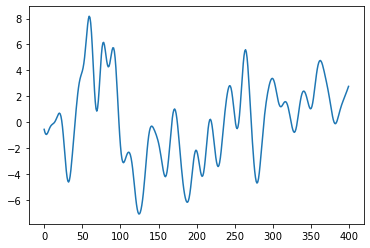

In [ ]:
plt.plot(xb[0][0].to('cpu').numpy())

In [ ]:
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [ ]:
splits

(array([     0,      1,      2, ..., 103451, 103452, 103453]),
 array([103454, 103455, 103456, ..., 134591, 134592, 134593]))

In [ ]:
learn = TSForecaster(x, y, splits=splits, arch=None, arch_config=dict(fc_dropout=.5), metrics=mae, bs=512, 
                         partial_n=.1, train_metrics=True)

SuggestedLRs(valley=3.0199516913853586e-05)

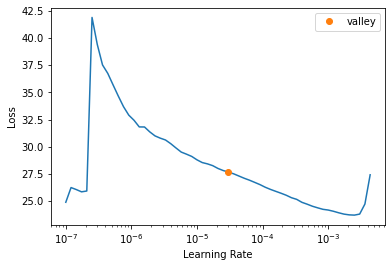

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(50, 3e-5)

epoch,train_loss,mae,time
0,25.173622,3.608815,00:05
1,24.929665,3.563651,00:05
2,24.462009,3.522667,00:05
3,25.698538,3.431537,00:05
4,23.974386,3.352218,00:05
5,22.580341,3.258568,00:05
6,21.513647,3.211572,00:05
7,20.432396,3.140452,00:05
8,19.476246,3.053705,00:05
9,18.601572,2.997290,00:05


In [ ]:
in_valid, pred_valid, true_valid = learn.get_preds(with_input=True)

In [ ]:
in_valid.shape

torch.Size([31140, 1, 400])

In [ ]:
pred_valid.shape

torch.Size([31140, 100])

In [ ]:
true_valid.shape

torch.Size([31140, 100])

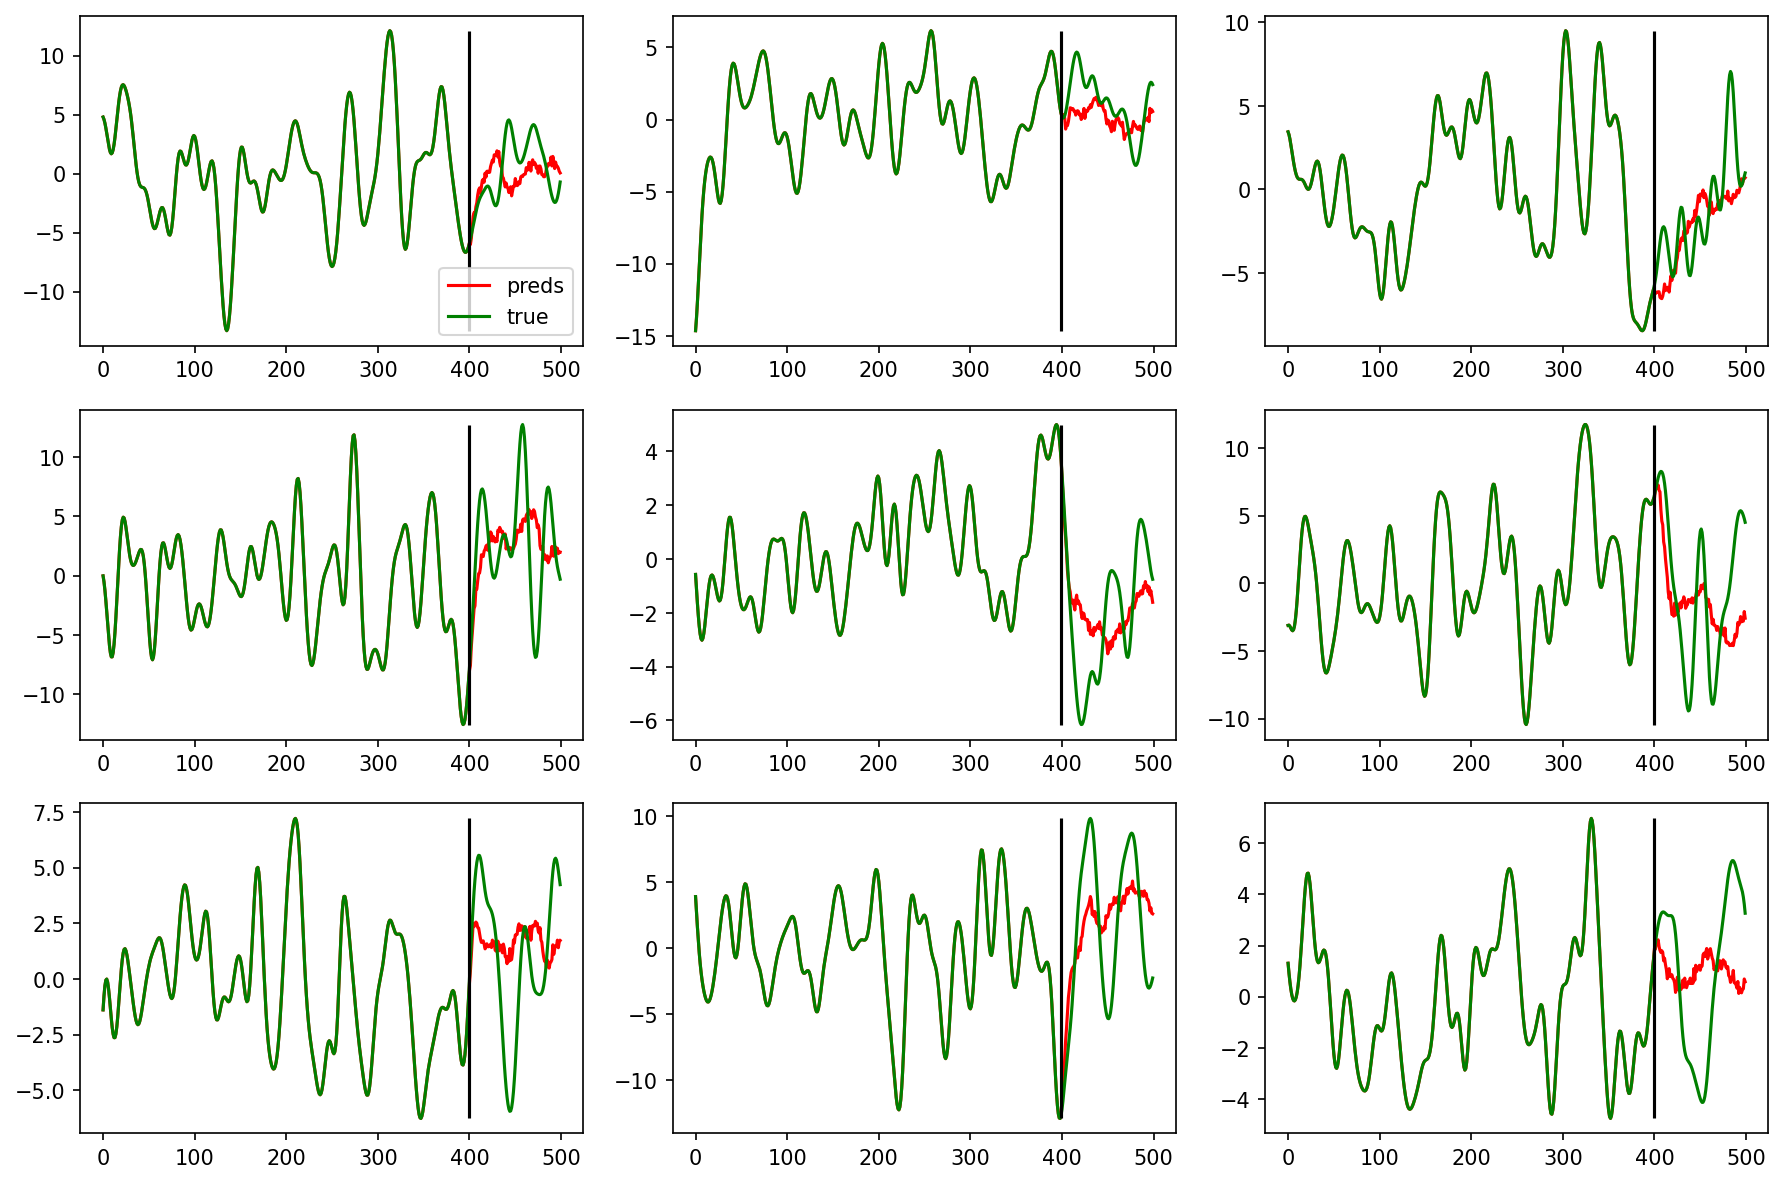

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12,8), dpi=150)
for i, ax in enumerate(axes.flat):
    plot_idx = np.random.choice(np.arange(0, len(in_valid)))
    true = np.concatenate([in_valid.numpy()[plot_idx,-1,:].reshape(-1), true_valid.numpy()[plot_idx,:].reshape(-1)])
    pred = np.concatenate([in_valid.numpy()[plot_idx,-1,:].reshape(-1), pred_valid[plot_idx,:].reshape(-1)])
    ax.plot(pred, color='red', label='preds')
    ax.plot(true, color='green', label='true')
    ax.vlines(trn_len-1, np.min(true), np.max(true), color='black')
    if i == 0: ax.legend()
fig.tight_layout();

In [ ]:
learn.model

InceptionTimePlus(
  (backbone): Sequential(
    (0): InceptionBlockPlus(
      (inception): ModuleList(
        (0): InceptionModulePlus(
          (bottleneck): ConvBlock(
            (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
          )
          (convs): ModuleList(
            (0): ConvBlock(
              (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
            )
            (1): ConvBlock(
              (0): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
            )
            (2): ConvBlock(
              (0): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
            )
          )
          (mp_conv): Sequential(
            (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
            (1): ConvBlock(
              (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
            )
          )
          (concat): Concat(dim=1)
      

In [ ]:
data.shape

(778, 173, 500)

In [ ]:
X = torch.from_numpy(np.concatenate(data, axis=0))[:,:400].squeeze(1)

In [ ]:
X = torch.tensor(x, dtype=torch.float32)

In [ ]:
X.shape

torch.Size([134594, 1, 400])

In [ ]:
x.shape

torch.Size([134594, 1, 400])

In [ ]:
SlidingWindowSplitter??

In [ ]:
X, y = SlidingWindowSplitter(30, horizon=1)(X)

MemoryError: Unable to allocate 361. GiB for an array with shape (134534, 30, 400, 30) and data type float64

[<matplotlib.lines.Line2D>]

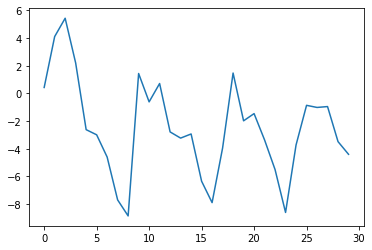

In [ ]:
plt.plot(X[0][0])

In [ ]:
x.squeeze().shape

torch.Size([134594, 400])

[<matplotlib.lines.Line2D>]

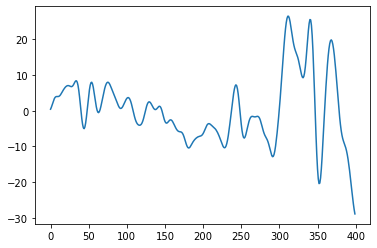

In [ ]:
plt.plot(x.squeeze()[0])

In [ ]:
y.shape

(134564, 300)

In [ ]:
TSSplitter??

In [ ]:
spl = (splits[0], splits[1][:-30])

In [ ]:
spl

(array([     0,      1,      2, ..., 103451, 103452, 103453]),
 array([103454, 103455, 103456, ..., 134561, 134562, 134563]))

In [ ]:
splits = create_splits(mats)

In [ ]:
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [ ]:
TSForecaster??

In [ ]:
#splits = TSSplitter()(y)
batch_tfms = [TSStandardize(by_var=True)]
learn = TSForecaster(x, y, splits=spl, batch_tfms=batch_tfms, arch=None, arch_config=dict(fc_dropout=.5), metrics=mae, bs=128, 
                         partial_n=.1, train_metrics=True)

In [ ]:
learn.fit_one_cycle(30)

epoch,train_loss,mae,time
0,18.868866,3.218201,00:06
1,17.290142,2.993946,00:06
2,17.108524,2.998340,00:06
3,16.940899,2.950398,00:06
4,16.245564,2.933988,00:06
5,16.070183,2.921601,00:06
6,16.117336,2.902923,00:06
7,15.815660,2.882623,00:06
8,15.134312,2.804292,00:06
9,14.659487,2.765582,00:06


In [ ]:
in_valid, pred_valid, true_valid = learn.get_preds(with_input=True)

In [ ]:
in_valid.shape

torch.Size([31110, 1, 400])

In [ ]:
pred_valid.shape

torch.Size([31110, 100])

In [ ]:
true_valid.shape

torch.Size([31110, 100])

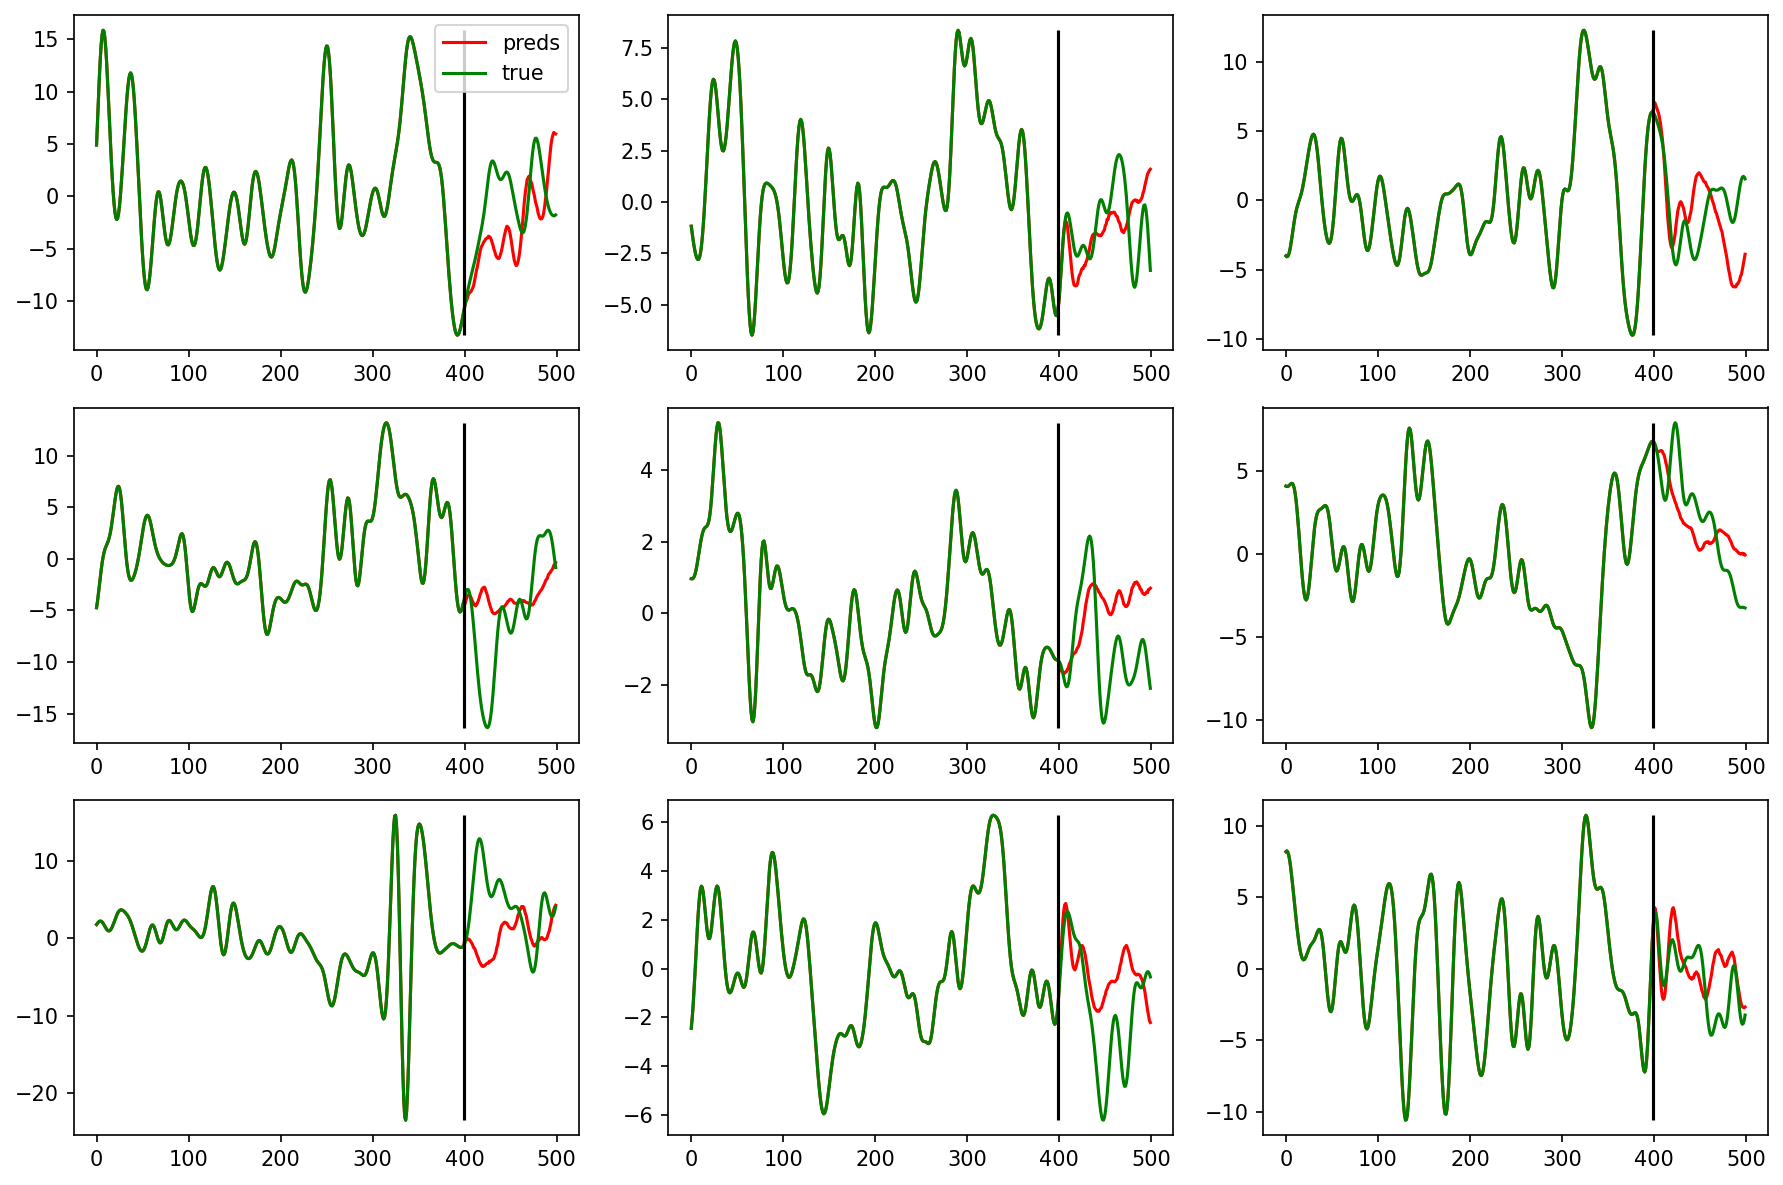

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12,8), dpi=150)
for i, ax in enumerate(axes.flat):
    plot_idx = np.random.choice(np.arange(0, len(in_valid)))
    true = np.concatenate([in_valid.numpy()[plot_idx,-1,:].reshape(-1), true_valid.numpy()[plot_idx,:].reshape(-1)])
    pred = np.concatenate([in_valid.numpy()[plot_idx,-1,:].reshape(-1), pred_valid[plot_idx,:].reshape(-1)])
    ax.plot(pred, color='red', label='preds')
    ax.plot(true, color='green', label='true')
    ax.vlines(trn_len-1, np.min(true), np.max(true), color='black')
    if i == 0: ax.legend()
fig.tight_layout();

Dataset: Sunspots
downloading data...
...done. Path = data/forecasting/Sunspots.csv


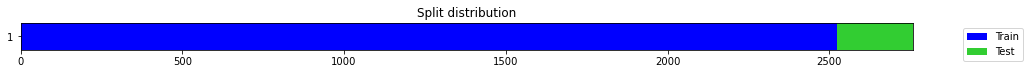

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=double, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

In [ ]:
ts = get_forecasting_time_series('Sunspots')
if ts is not None: # This is to prevent a test fail when the data server is not available
    X, y = SlidingWindowSplitter(60, horizon=1)(ts)
    splits = TSSplitter(235)(y)
    batch_tfms = [TSStandardize(by_var=True)]
    learn = TSForecaster(X, y, splits=splits, batch_tfms=batch_tfms, arch=None, arch_config=dict(fc_dropout=.5), metrics=mae, bs=512, 
                         partial_n=.1, train_metrics=True)
    #learn.fit_one_cycle(1)